In [32]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import config
import pandas as pd
import numpy as np
import joblib


from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters

from utils.constants import (
    MODEL_STANDARD_DIR, 
    WINDOW_SIZE_STANDARD_AUTOENCODER, 
    FEATURES, 
    DATA_DIR, 
    DATA_TRAIN_DIR, 
    DATA_TEST_DEPARTING_DIR, 
    DATA_TEST_LANDING_DIR,
    DATA_TEST_MANOEUVER_DIR, 
    DATA_TEST_NOISE_DIR, 
    DATA_VALIDATION_DIR, 
    DIFF_DATA, 
    DIFF_FEATURES, 
    K_LAG, 
    K_ORDER
)

from utils.preprocessing import (
    get_windows_data, 
    filter_outliers, 
    diff_data
)

from utils.evaluation import test_normal_dist

from tensorflow.keras.models import load_model
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.autoencoder import autoencoder_model_feature_pipeline

In [9]:
print(os.getcwd())

/home/jovyan/adsb_pynqz2


In [11]:
if not os.path.exists(MODEL_STANDARD_DIR):
    os.makedirs(MODEL_STANDARD_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [12]:
!yes | unzip data.zip

Archive:  data.zip
replace data/test/manoeuver/CFG114.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/CFG114.csv  
replace data/test/manoeuver/VIR63.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/VIR63.csv  
replace data/test/manoeuver/BAW60T.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/BAW60T.csv  
replace data/test/manoeuver/DLH444.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/DLH444.csv  
replace data/test/manoeuver/BAW175.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/BAW175.csv  
replace data/test/manoeuver/BAW9L.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/BAW9L.csv  
replace data/test/manoeuver/BAW9154.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/manoeuver/BAW9154.csv  
replace data/test/departing/CFG114.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: data/test/departing/CFG1

In [16]:
data_dict = {
    "train": [],
    "validation": [],
    "test_noise": [],
    "test_landing": [],
    "test_departing": [],
    "test_manoeuver": [],
}

In [17]:
paths = {
    "train": DATA_TRAIN_DIR,
    "validation": DATA_VALIDATION_DIR,
    "test_noise": DATA_TEST_NOISE_DIR,
    "test_landing": DATA_TEST_LANDING_DIR,
    "test_departing": DATA_TEST_DEPARTING_DIR,
    "test_manoeuver": DATA_TEST_MANOEUVER_DIR
}

In [18]:
for key, path in paths.items():
    files = os.listdir(path)
    
    for file in files:
        file_path = os.path.join(path, file)
        
        # Check if the path is a file
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path)
            
            if key == "train":
                df = filter_outliers(df, cols=["longitude", "latitude", "altitude", "groundspeed", "x", "y"], std=5)
            elif key == "validation":
                df = filter_outliers(df, cols=["longitude", "latitude", "altitude", "groundspeed", "x", "y"], std=8)

            if DIFF_DATA:
                df = diff_data(df, cols=DIFF_FEATURES, lag=K_LAG, order=K_ORDER)
            
            data_dict[key].append(df)

In [3]:
model = load_model(MODEL_STANDARD_DIR)

2024-07-24 15:26:17.813613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Initialize lists to store windowed data and labels for validation
validation_windows_list = []
validation_labels_list = []

# Iterate over each DataFrame in the validation data
for df in tqdm(data_dict["validation"], desc="Processing validation data"):
    if df.empty:
        continue  # Skip empty DataFrames
    
    try:
        # Extract windowed data and labels
        windowed_data, windowed_labels = get_windows_data(
            df[FEATURES], 
            [0] * df.shape[0], 
            window_size=WINDOW_SIZE_STANDARD_AUTOENCODER, 
            tsfresh=True
        )
        
        # Append extracted data and labels to lists
        validation_windows_list.append(windowed_data)
        validation_labels_list.append(windowed_labels)
    
    except Exception as e:
        print(f"Error processing DataFrame: {e}")

Processing validation data: 100%|██████████| 9/9 [00:30<00:00,  3.43s/it]


In [21]:
# Assert that the number of feature sets matches the number of label sets
assert len(validation_windows_list) == len(validation_labels_list)

# Initialize lists and arrays to store the extracted features and labels
extracted_val_features_list = []
concatenated_val_labels = np.array([])

# Feature extraction loop with progress bar
for i in tqdm(range(len(validation_windows_list)), desc="Extracting validation features"):
    try:
        # Extract features using tsfresh
        features = extract_features(
            validation_windows_list[i], 
            column_id="id", 
            column_sort="time", 
            default_fc_parameters=MinimalFCParameters()
        )
        
        # Impute missing values
        imputed_features = impute(features)
        
        # Append extracted features and labels to respective lists
        extracted_val_features_list.append(imputed_features)
        concatenated_val_labels = np.append(concatenated_val_labels, validation_labels_list[i])
    
    except Exception as e:
        # Log errors and continue
        print(f"Error processing index {i}: {e}")
        continue

# Concatenate extracted features into a single DataFrame
if extracted_val_features_list:  # Ensure the list is not empty
    X_val = pd.concat(extracted_val_features_list, ignore_index=True)
else:
    X_val = pd.DataFrame()

# Assign labels to y_val
y_val = concatenated_val_labels

# Verify the final shapes
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

Extracting validation features: 100%|██████████| 9/9 [00:54<00:00,  6.09s/it]

Shape of X_val: (40067, 50)
Shape of y_val: (40067,)


In [26]:
autoencoder_model_feature_pipeline = joblib.load(MODEL_STANDARD_DIR + '/fitted_pipeline.pkl')
X_val_n = autoencoder_model_feature_pipeline.transform(X_val)

In [27]:
preds_val = model.predict(X_val_n)

1253/1253 [==============================] - 1s 1ms/step


In [28]:
# Calculate reconstruction errors using vectorized operations
reconstruction_errors = np.linalg.norm(X_val_n - preds_val, axis=1) ** 2

# Create a DataFrame to store the reconstruction errors
reconstruction_errors_df = pd.DataFrame({"reconstruction_errors": reconstruction_errors})

# Print the first few rows of the DataFrame to verify the results
print(reconstruction_errors_df.head())

   reconstruction_errors
0               6.362383
1               6.537131
2               6.669594
3               6.916628
4               6.923093


In [29]:
reconstruction_errors_df.describe()

,reconstruction_errors
count,40067.000000
mean,18.271126
std,43.070344
min,1.651086
25%,7.181393
50%,7.819049
75%,10.243171
max,1159.880985


<Figure size 1000x600 with 0 Axes>

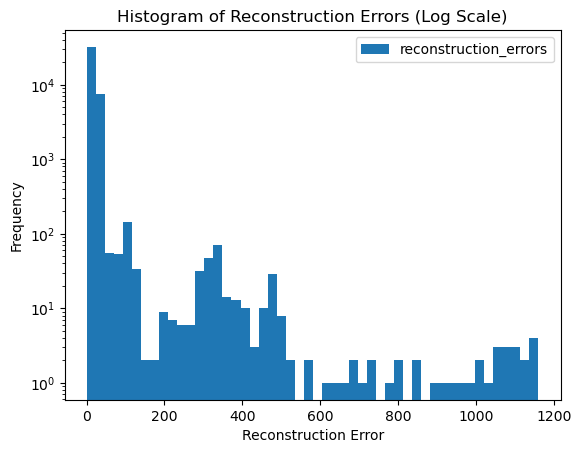

In [31]:
plt.figure(figsize=(10, 6))
reconstruction_errors_df.plot.hist(bins=50, log=True)
plt.title('Histogram of Reconstruction Errors (Log Scale)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

In [33]:
test_normal_dist(reconstruction_errors_df.values)

p-value: 0.0
The null hypothesis can be rejected (data is not normal).


In [34]:
mu = np.mean(reconstruction_errors_df["reconstruction_errors"].values)
mu

18.27112576472031

In [35]:
std = np.std(reconstruction_errors_df["reconstruction_errors"].values)
std

43.06980700510487